# Ray et al 2013 Prototyping
**Authorship:**
Adam Klie, *09/03/2022*
***
**Description:**
Notebook to protoype MT and ST models
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


/mnt/beegfs/users/aklie/projects/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/mnt/beegfs/users/aklie/projects/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


Already up to date.


In [2]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/ray13"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/ray13"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/ray13"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/ray13"
eu.settings.verbosity = logging.ERROR

# Load in the SetA training `SeqData`'s for single task and multi-task models

In [3]:
# Load in the training SetA processed data for single task and multitask models
sdata_training_ST = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "norm_setA_processed_ST.h5sd"))
sdata_training_MT = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "norm_setA_processed_MT.h5sd"))

In [4]:
# Grab the prediction columns for single task and multitask
target_mask_ST = sdata_training_ST.seqs_annot.columns.str.contains("RNCMPT")
target_cols_ST = sdata_training_ST.seqs_annot.columns[target_mask_ST]
target_mask_MT = sdata_training_MT.seqs_annot.columns.str.contains("RNCMPT")
target_cols_MT = sdata_training_MT.seqs_annot.columns[target_mask_MT]

In [5]:
# Load the test data
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, "norm_setB_processed_ST.h5sd"))

In [59]:
# Load in the Set B presence/absence predictions
b_presence_absence = np.load(os.path.join(eu.settings.dataset_dir, "setB_binary.npy"))
setB_observed = sdata_test.seqs_annot[target_cols_ST]

# Single task

## Train

In [6]:
# Instantiation function
from pytorch_lightning import seed_everything
def prep_new_model(
    seed,
    conv_dropout = 0,
    fc_dropout = 0,
    batchnorm = True
):
    model = eu.models.DeepBind(
        input_len=41, # Length of padded sequences
        output_dim=1, # Number of multitask outputs
        strand="ss",
        task="regression",
        mode="rbp",
        aggr="max",
        conv_kwargs=dict(channels=[4, 64], conv_kernels=[16], dropout_rates=conv_dropout, batchnorm=batchnorm),
        fc_kwargs=dict(hidden_dims=[128], dropout_rate=fc_dropout, batchnorm=batchnorm),
        optimizer="adam",
        #optimizer_kwargs={"nesterov": True, "momentum":0.9, "weight_decay": 1e-5},
        lr=0.0005,
        scheduler_patience=3
    )

    # Set a seed
    seed_everything(seed)
    
    # Initialize the model prior to conv filter initialization
    eu.models.base.init_weights(model)

    # Return the model
    return model 

# Test out a model before training
model = prep_new_model(0)
print(model.summary())
sdataloader = sdata_training_ST[:64].to_dataset(transform_kwargs={"transpose": True}).to_dataloader()
test_seqs = next(iter(sdataloader))
print(model(test_seqs[1], test_seqs[2]).size())

Global seed set to 0


Model: DeepBind
Input length: 41
Output dimension: 1
Strand: ss
Task: regression
Aggregation: max
Loss function: mse_loss
Optimizer: adam
	Optimizer parameters: {}
Learning rate: 0.0005
Scheduler: lr_scheduler
Scheduler patience: 3
  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 4.3 K 
2 | max_pool  | MaxPool1d                 | 0     
3 | avg_pool  | AvgPool1d                 | 0     
4 | fcn       | BasicFullyConnectedModule | 16.9 K
--------------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)
No transforms given, assuming just need to tensorize).
torch.Size([64, 1])


In [11]:
# Set-up trial and task
trial=0
col_num=9

In [12]:
# Initialize the model
trial = trial+1
model = prep_new_model(seed=trial, conv_dropout=0.25, fc_dropout=0.25, batchnorm=True)

Global seed set to 1


In [13]:
# Choose a target
target_col = target_cols_ST[col_num]
target_col, f"trial_{trial}"

('RNCMPT00010', 'trial_1')

In [15]:
# Train the model
eu.train.fit(
    model=model, 
    sdata=sdata_training_ST, 
    gpus=1, 
    target=target_col,
    train_key="train_val",
    epochs=25,
    early_stopping_metric="val_loss",
    early_stopping_patience=5,
    batch_size=100,
    num_workers=0,
    name="prototype",
    version=f"DeepBind_ST_{target_col}_v{trial}",
    seed=trial,
    verbosity=logging.ERROR
)

Global seed set to 1


Dropping 9 sequences with NaN targets.
No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 4.3 K 
2 | max_pool  | MaxPool1d                 | 0     
3 | avg_pool  | AvgPool1d                 | 0     
4 | fcn       | BasicFullyConnectedModule | 16.9 K
--------------------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


No transforms given, assuming just need to tensorize).


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.742


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.718


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.703


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.677


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.655


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.655. Signaling Trainer to stop.


## Evaluate

## Loss and metric curves

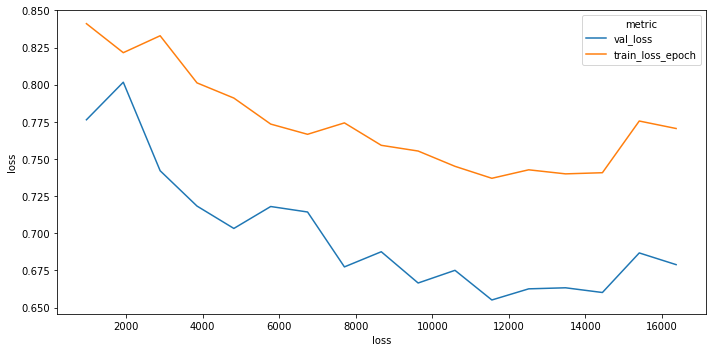

In [16]:
eu.pl.loss_curve(os.path.join(eu.settings.logging_dir, "prototype", f"DeepBind_ST_{target_col}_v{trial}"))

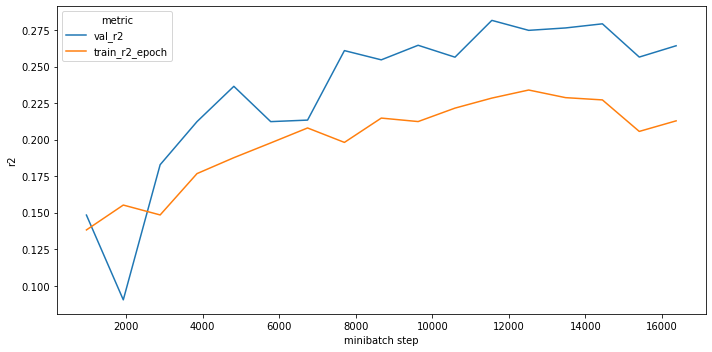

In [17]:
eu.pl.metric_curve(os.path.join(eu.settings.logging_dir, "prototype", f"DeepBind_ST_{target_col}_v{trial}"), metric="r2")

## Test set predictions

In [18]:
model_file = glob.glob(os.path.join(eu.settings.logging_dir, "prototype", f"DeepBind_ST_{target_col}_v{trial}", "checkpoints", "*"))[0]
test_model = eu.models.DeepBind.load_from_checkpoint(model_file)

In [19]:
eu.settings.dl_num_workers = 0
eu.predict.predictions(
    test_model,
    sdata=sdata_test, 
    target=target_col,
    name="prototype",
    version=f"DeepBind_ST_{target_col}_v{trial}",
    suffix=f"_v{trial}_ST",
    file_label="test"
)

No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00010_predictions_v1_ST


['RNCMPT00010'] ['RNCMPT00010_predictions_v1_ST']


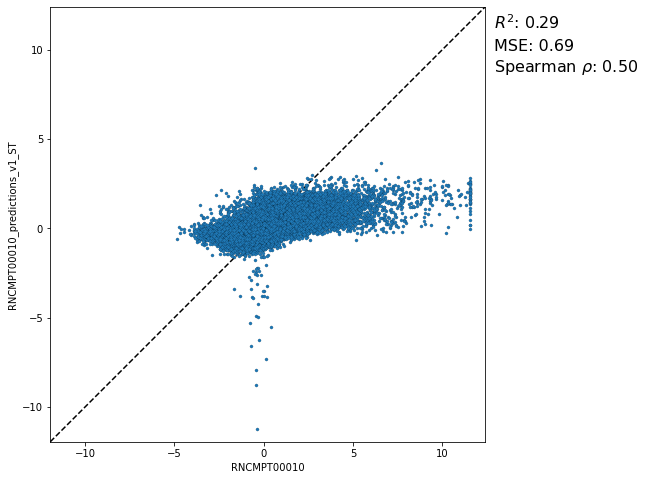

In [20]:
eu.pl.performance_scatter(
    sdata_test,
    targets=target_col,
    predictions=f"{target_col}_predictions_v{trial}_ST"
)

In [21]:
eu.predict.column_rnac_metrics_apply(
    sdata_test,
    b_presence_absence,
    target_col,
    n_kmers=100,
    use_calc_auc=True,
    verbose=True,
    preds_suffix=f"_predictions_v{trial}_ST"
)

NameError: name 'b_presence_absence' is not defined

## Train and val predictions

In [68]:
# Get predictions on the training data
eu.settings.dl_num_workers = 0
eu.predict.train_val_predictions(
    model,
    sdata=sdata_training_ST, 
    target=target_col,
    train_key="train_val",
    name="prototype",
    version=f"DeepBind_ST_{target_col}_v{trial}",
    suffix=f"_v{trial}_ST",
)

No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00002_predictions_v1_ST


['RNCMPT00002'] ['RNCMPT00002_predictions_v1_ST']


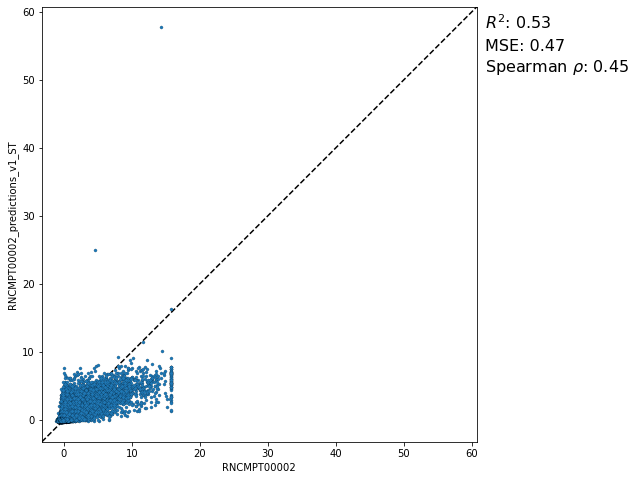

In [70]:
eu.pl.performance_scatter(
    sdata_training_ST,
    targets=target_col,
    predictions=f"{target_col}_predictions_v{trial}_ST"
)

# Intepret

In [22]:
eu.interpret.feature_attribution(
    test_model,
    sdata_test,
    saliency_method="InputXGradient",
    suffix=f"_{target_col}__v{trial}_ST"
)

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/945 [00:00<?, ?it/s]

Importance values: 0it [00:00, ?it/s]

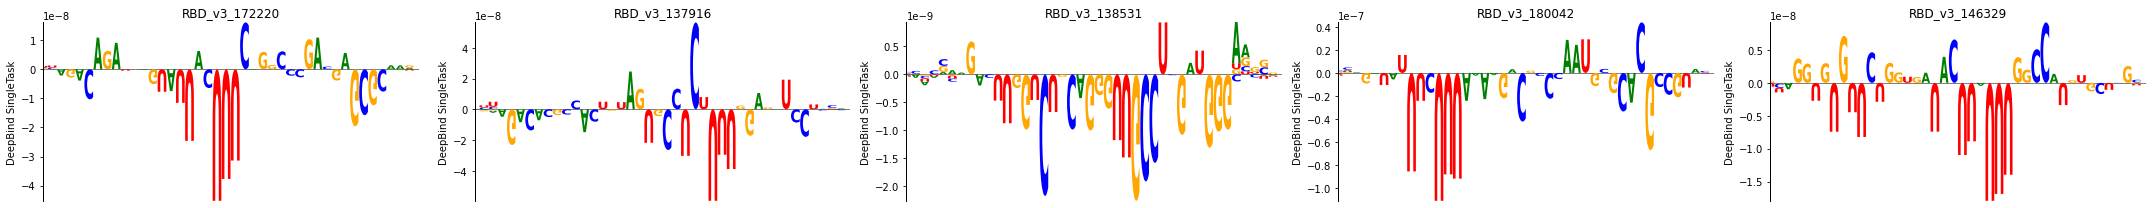

In [23]:
ind = list(sdata_test[target_col].sort_values(ascending=False).index[:5])
eu.pl.lm_multiseq_track(
    sdata_test,
    seq_ids=ind,
    uns_keys=f"InputXGradient_imps_{target_col}__v{trial}_ST",
    alphabet="RNA",
    width=30,
    height=3,
    ylabels="DeepBind SingleTask"
    #save=os.path.join(figure_dir, "prototype", f"model_top3_feature_attr_{target_col}__v{trial}_ST.pdf")
)

In [24]:
# Grab the pfms for the 16 filters of each single task model
eu.interpret.generate_pfms(
    test_model, 
    sdata_test, 
    key_name=f"pfms_{target_col}__v{trial}_ST", 
    alphabet="RNA"
)

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/945 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/64 [00:00<?, ?it/s]

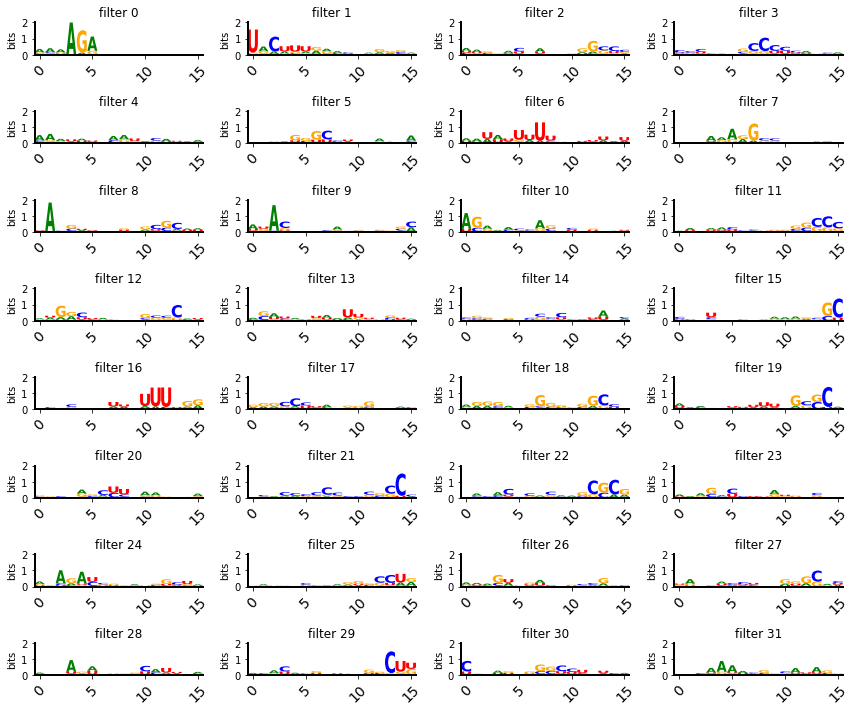

In [25]:
# Visualizations for all 16 filters for DeepBind SingleTask models
eu.pl.lm_multifilter_viz(
    sdata_test,
    filter_ids=range(0,32),
    uns_key=f"pfms_{target_col}__v{trial}_ST",
    titles=[f"filter {i}" for i in range(32)],
    num_rows=8,
    num_cols=4,
    #save=os.path.join(figure_dir, "filter_viz", f"model_filters_viz_{target_col}_ST.pdf")
)

# Multitask

## Train

In [117]:
# Instantiation function
from pytorch_lightning import seed_everything

In [118]:
# Instantiate the model
conv_dropout = 0.5
fc_dropout = 0.5
batchnorm = True
model = eu.models.DeepBind(
    input_len=41, # Length of padded sequences
    output_dim=len(target_cols_MT), # Number of multitask outputs
    strand="ss",
    task="regression",
    mode="rbp",
    conv_kwargs=dict(channels=[4, 1024], conv_kernels=[16], dropout_rates=conv_dropout, batchnorm=batchnorm),
    mp_kwargs=dict(kernel_size=8),
    fc_kwargs=dict(hidden_dims=[512], dropout_rate=fc_dropout, batchnorm=batchnorm),
    optimizer="adam",
    lr=0.0005,
    scheduler_patience=3
)

# Set a seed
seed_everything(trial)

# Initialize the model prior to conv filter initialization
eu.models.base.init_weights(model)

# Test out a model before training
print(model.summary())
sdataloader = sdata_training_MT[:64].to_dataset(transform_kwargs={"transpose": True}).to_dataloader()
test_seqs = next(iter(sdataloader))
print(model(test_seqs[1], test_seqs[2]).size())

Global seed set to 17


Model: DeepBind
Input length: 41
Output dimension: 233
Strand: ss
Task: regression
Aggregation: max
Loss function: mse_loss
Optimizer: adam
	Optimizer parameters: {}
Learning rate: 0.0005
Scheduler: lr_scheduler
Scheduler patience: 3
  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 68.6 K
2 | max_pool  | MaxPool1d                 | 0     
3 | avg_pool  | AvgPool1d                 | 0     
4 | fcn       | BasicFullyConnectedModule | 1.2 M 
--------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.953     Total estimated model params size (MB)
No transforms given, assuming just need to tensorize).
torch.Size([64, 233])


In [41]:
# Set-up trial and task
#trial=3

In [119]:
# Initialize the model
trial = trial+1
f"trial_{trial}"

'trial_18'

In [120]:
# Train the model
eu.train.fit(
    model=model, 
    sdata=sdata_training_MT, 
    gpus=1, 
    target=target_cols_MT,
    train_key="train_val",
    epochs=100,
    early_stopping_metric="val_loss",
    early_stopping_patience=5,
    batch_size=2048,
    num_workers=4,
    name="prototype",
    version=f"DeepBind_MT_v{trial}",
    seed=trial,
    verbosity=logging.ERROR
)

Global seed set to 18


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 68.6 K
2 | max_pool  | MaxPool1d                 | 0     
3 | avg_pool  | AvgPool1d                 | 0     
4 | fcn       | BasicFullyConnectedModule | 1.2 M 
--------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.953     Total estimated model params size (MB)


No transforms given, assuming just need to tensorize).


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 18
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.891


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.852


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.837


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.821


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.813


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.808


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.801


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.793


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.768


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.763


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.754


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.753


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.752


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.751


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.751


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.751. Signaling Trainer to stop.


## Evaluate

## Loss and metric curves

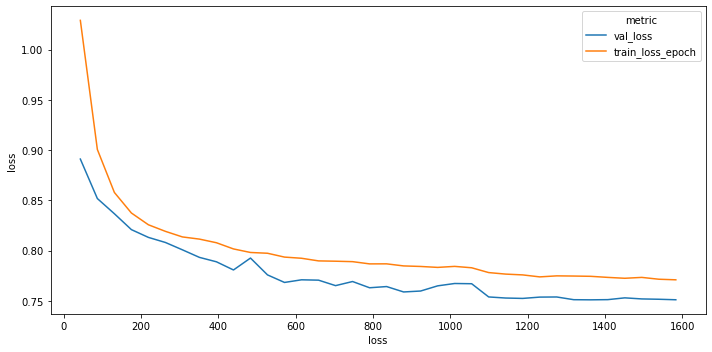

In [121]:
eu.pl.loss_curve(os.path.join(eu.settings.logging_dir, "prototype", f"DeepBind_MT_v{trial}"))

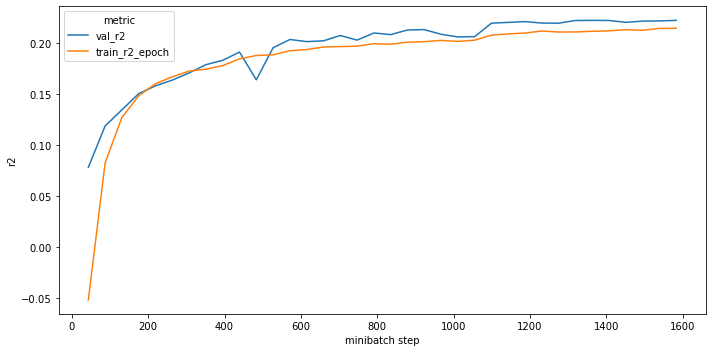

In [122]:
eu.pl.metric_curve(os.path.join(eu.settings.logging_dir, "prototype", f"DeepBind_MT_v{trial}"), metric="r2")

## Test set predictions

In [123]:
model_file = glob.glob(os.path.join(eu.settings.logging_dir, "prototype", f"DeepBind_MT_v{trial}", "checkpoints", "*"))[0]
test_model = eu.models.DeepBind.load_from_checkpoint(model_file)

In [124]:
eu.settings.dl_num_workers = 0
eu.predict.predictions(
    test_model,
    sdata=sdata_test, 
    target=target_cols_MT,
    name="prototype",
    version=f"DeepBind_MT_v{trial}",
    suffix=f"_v{trial}_MT",
    file_label="test"
)

No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pandas/core/frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


SeqData object modified:
    seqs_annot:
        + RNCMPT00067_predictions_v18_MT, RNCMPT00101_predictions_v18_MT, RNCMPT00149_predictions_v18_MT, RNCMPT00256_predictions_v18_MT, RNCMPT00108_predictions_v18_MT, RNCMPT00153_predictions_v18_MT, RNCMPT00200_predictions_v18_MT, RNCMPT00077_predictions_v18_MT, RNCMPT00010_predictions_v18_MT, RNCMPT00090_predictions_v18_MT, RNCMPT00238_predictions_v18_MT, RNCMPT00197_predictions_v18_MT, RNCMPT00011_predictions_v18_MT, RNCMPT00094_predictions_v18_MT, RNCMPT00083_predictions_v18_MT, RNCMPT00176_predictions_v18_MT, RNCMPT00281_predictions_v18_MT, RNCMPT00107_predictions_v18_MT, RNCMPT00283_predictions_v18_MT, RNCMPT00059_predictions_v18_MT, RNCMPT00156_predictions_v18_MT, RNCMPT00147_predictions_v18_MT, RNCMPT00040_predictions_v18_MT, RNCMPT00182_predictions_v18_MT, RNCMPT00127_predictions_v18_MT, RNCMPT00172_predictions_v18_MT, RNCMPT00076_predictions_v18_MT, RNCMPT00120_predictions_v18_MT, RNCMPT00119_predictions_v18_MT, RNCMPT00216_predictio

In [125]:
col_num = 0
target_col = target_cols_MT[col_num]
target_col, f"trial_{trial}"

('RNCMPT00001', 'trial_18')

['RNCMPT00001'] ['RNCMPT00001_predictions_v18_MT']


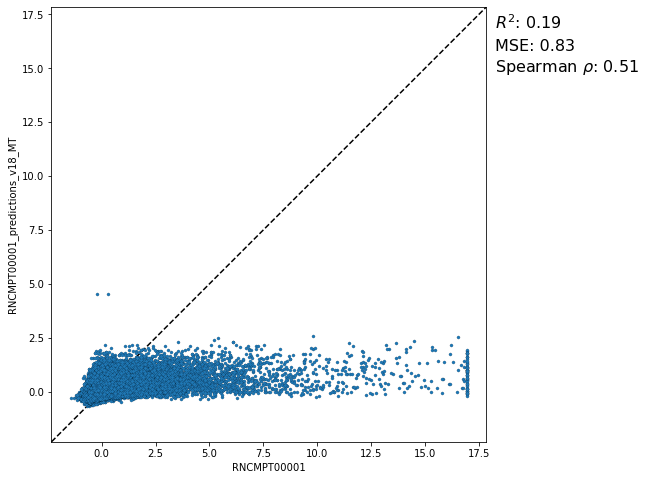

In [126]:
eu.pl.performance_scatter(
    sdata_test,
    targets=target_col,
    predictions=f"{target_col}_predictions_v{trial}_MT"
)

['RNCMPT00001_predictions_v17_ST'] ['RNCMPT00001_predictions_v18_MT']


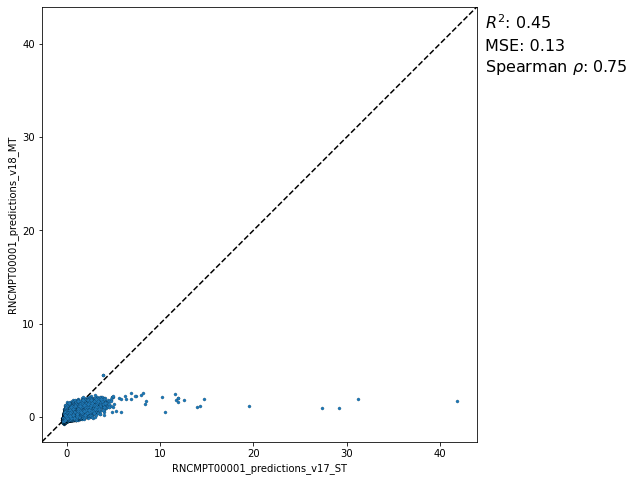

In [128]:
eu.pl.performance_scatter(
    sdata_test,
    targets=f"{target_col}_predictions_v{trial-1}_ST",
    predictions=f"{target_col}_predictions_v{trial}_MT"
)

In [21]:
eu.predict.column_rnac_metrics_apply(
    sdata_test,
    b_presence_absence,
    target_col,
    n_kmers=100,
    use_calc_auc=True,
    verbose=True,
    preds_suffix=f"_predictions_v{trial}_MT"
)

NameError: name 'b_presence_absence' is not defined

## Train and val predictions

In [68]:
# Get predictions on the training data
eu.settings.dl_num_workers = 0
eu.predict.train_val_predictions(
    model,
    sdata=sdata_training_ST, 
    target=target_col,
    train_key="train_val",
    name="prototype",
    version=f"DeepBind_ST_{target_col}_v{trial}",
    suffix=f"_v{trial}_ST",
)

No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00002_predictions_v1_ST


['RNCMPT00002'] ['RNCMPT00002_predictions_v1_ST']


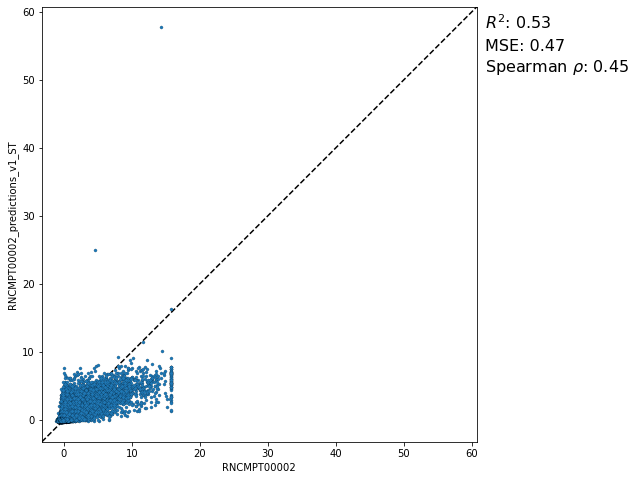

In [70]:
eu.pl.performance_scatter(
    sdata_training_ST,
    targets=target_col,
    predictions=f"{target_col}_predictions_v{trial}_ST"
)

# Intepret

In [129]:
eu.interpret.feature_attribution(
    test_model,
    sdata_test,
    saliency_method="InputXGradient",
    suffix=f"_{target_col}_v{trial}_MT",
    target=col_num
)

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/945 [00:00<?, ?it/s]

Importance values: 0it [00:00, ?it/s]

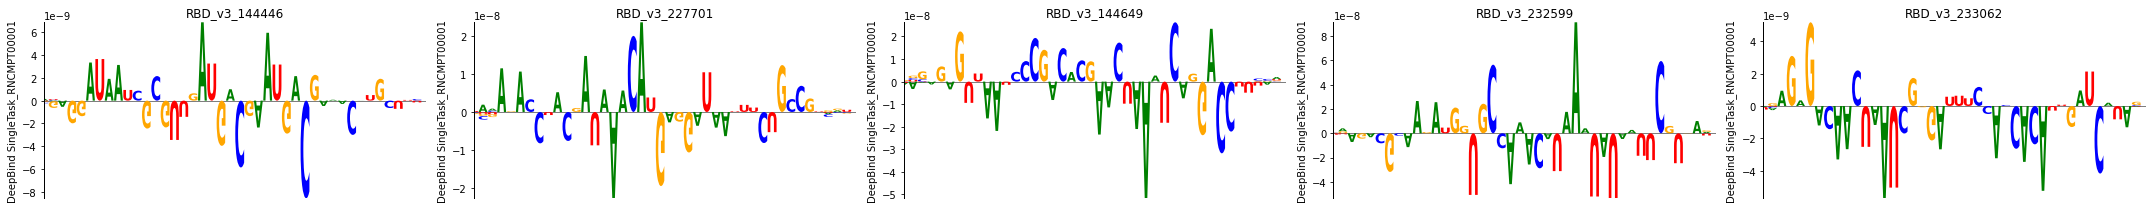

In [130]:
ind = list(sdata_test[target_col].sort_values(ascending=False).index[:5])
eu.pl.lm_multiseq_track(
    sdata_test,
    seq_ids=ind,
    uns_keys=f"InputXGradient_imps_{target_col}_v{trial}_MT",
    alphabet="RNA",
    width=30,
    height=3,
    ylabels=f"DeepBind MultiTask_{target_col}"
    #save=os.path.join(figure_dir, "prototype", f"model_top3_feature_attr_{target_col}__v{trial}_ST.pdf")
)

In [ ]:
# Grab the pfms for the 16 filters of each single task model
eu.interpret.generate_pfms(
    test_model, 
    sdata_test, 
    key_name=f"pfms_v{trial}_MT", 
    alphabet="RNA"
)

In [ ]:
# Visualizations for all 16 filters for DeepBind SingleTask models
eu.pl.lm_multifilter_viz(
    sdata_test,
    filter_ids=range(0,32),
    uns_key=f"pfms_{target_col}__v{trial}_ST",
    titles=[f"filter {i}" for i in range(32)],
    num_rows=8,
    num_cols=4,
    #save=os.path.join(figure_dir, "filter_viz", f"model_filters_viz_{target_col}_ST.pdf")
)

---

# Scratch